In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b", api_key=groq_api_key)
llm.invoke("hi")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'We need to respond as ChatGPT. The user says "hi". Should respond friendly. No policy issues.'}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 72, 'total_tokens': 113, 'completion_time': 0.081474879, 'prompt_time': 0.002441754, 'queue_time': 0.046530765, 'total_time': 0.083916633}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--dfe4396d-8686-4a4f-967f-4ccfaa7450ba-0', usage_metadata={'input_tokens': 72, 'output_tokens': 41, 'total_tokens': 113})

In [2]:
from typing_extensions import Literal, TypedDict
import operator
from typing import Annotated, List
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

In [3]:
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(description="Sections of the report")

planner = llm.with_structured_output(Sections)

In [20]:
from langgraph.graph import START, END, StateGraph
from langgraph.types import Send

class State(TypedDict):
    topic:str
    sections:list[Sections]
    completed_sections: Annotated[
        list, operator.add
    ]
    final_report: str

class WorkerState(TypedDict):
    section:Section
    completed_sections: Annotated[
        list, operator.add
    ]

In [27]:
def orchestrator(state:State):
    """Orchestrator that generates a plan for the report"""
    report_sections = planner.invoke(
        
           [ SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state["topic"]}"),]
        
    )
    print("Report Section:", report_sections)
    return {"sections": report_sections.sections}

def llm_call(state:WorkerState):
    """Worker writes a section of the report"""
    section = llm.invoke(
        
            [SystemMessage(content="Write a report section following the provided name and description. Include no preamble for each section.use Markdown formatting."),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"),
        ]
    )
    return{"completed_sections": [section.content]}

def assign_workers(state: State):
    """ Assign a worker to each section in the plan"""
    return [Send("llm_call", {"section":s}) for s in state["sections"]]

def synthesizer(state: State):
    """ Synthesize full report from sections"""
    completed_sections = state["completed_sections"]
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}

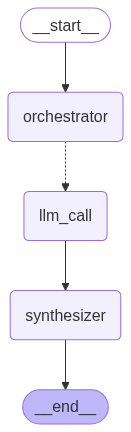

In [28]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

orchestrator_worker_builder = StateGraph(State)
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [29]:
state = orchestrator_worker.invoke({"topic": "crate a report on Machine Learning concpets"})
from IPython.display import Markdown
Markdown(state["final_report"])

Report Section: sections=[Section(name='Executive Summary', description='A concise overview of the report, highlighting the key machine learning concepts, their significance, and the main takeaways for readers.'), Section(name='Introduction to Machine Learning', description='Defines machine learning, its historical evolution, relationship to AI and statistics, and outlines the scope of the report.'), Section(name='Fundamental Concepts', description='Covers core ideas such as data representation, features, labels, training vs. testing, overfitting/underfitting, bias‑variance trade‑off, and the learning pipeline.'), Section(name='Supervised Learning', description='Explains the paradigm, key algorithms (linear regression, logistic regression, decision trees, SVM, k‑NN, neural networks), loss functions, and typical applications.'), Section(name='Unsupervised Learning', description='Describes clustering, dimensionality reduction, density estimation, and algorithms like k‑means, hierarchical

## Executive Summary

This report provides a concise overview of foundational and emerging machine‑learning concepts, emphasizing their practical significance and the strategic insights they deliver to organizations and practitioners.

- **Core Concepts**  
  - **Supervised Learning** – Predictive modeling using labeled data (e.g., regression, classification).  
  - **Unsupervised Learning** – Discovering hidden structure without explicit labels (e.g., clustering, dimensionality reduction).  
  - **Reinforcement Learning** – Decision‑making through interaction with an environment and reward feedback.  
  - **Deep Learning** – Hierarchical neural networks that excel in perception tasks such as image, speech, and language processing.  
  - **Transfer & Few‑Shot Learning** – Leveraging pre‑trained models to adapt quickly to new tasks with minimal data.

- **Significance**  
  - Enables data‑driven automation, improving efficiency and reducing human error.  
  - Drives competitive advantage by uncovering actionable insights from large, complex datasets.  
  - Facilitates personalization at scale, enhancing customer experience across industries.  
  - Supports real‑time decision making in critical domains (e.g., finance, healthcare, autonomous systems).

- **Main Takeaways**  
  1. **Strategic Alignment** – Successful ML initiatives require clear business objectives, robust data pipelines, and cross‑functional collaboration.  
  2. **Model Selection & Evaluation** – Choose algorithms that match the problem’s complexity, data availability, and interpretability needs; rigorously validate with appropriate metrics and cross‑validation.  
  3. **Ethics & Governance** – Proactively address bias, privacy, and regulatory compliance to build trustworthy AI systems.  
  4. **Scalability & Maintenance** – Deploy models using containerization, CI/CD pipelines, and monitoring to ensure performance over time.  
  5. **Continuous Learning** – Stay abreast of rapid advances (e.g., foundation models, prompt engineering) to sustain innovation.

Overall, mastering these concepts equips readers to design, implement, and govern machine‑learning solutions that deliver measurable value while navigating technical and ethical challenges.

---

## Introduction to Machine Learning

Machine learning (ML) is a subfield of artificial intelligence that focuses on the development of algorithms and statistical models enabling computers to perform tasks without explicit programming. By learning patterns from data, ML systems can make predictions, classify information, and uncover insights that would be infeasible to encode manually.

### Historical Evolution
- **1950s–1960s:** Early concepts emerged with the perceptron and symbolic AI approaches, emphasizing rule‑based reasoning.
- **1970s–1980s:** Introduction of decision trees, nearest‑neighbor methods, and the back‑propagation algorithm for neural networks revived interest in data‑driven learning.
- **1990s:** The rise of support vector machines, ensemble methods (e.g., boosting, bagging), and the proliferation of statistical learning theory formalized the field.
- **2000s:** Availability of large datasets and increased computational power spurred the resurgence of deep neural networks, leading to breakthroughs in computer vision, speech, and natural language processing.
- **2010s–present:** Integration of reinforcement learning, transfer learning, and generative models has expanded ML applications across industry, science, and everyday technology.

### Relationship to AI and Statistics
- **Artificial Intelligence:** ML is a core engine of modern AI, providing the learning capability that differentiates adaptive systems from static, rule‑based AI.
- **Statistics:** ML shares many foundations with statistical inference—probability theory, hypothesis testing, and model evaluation—but places a stronger emphasis on prediction accuracy, scalability, and algorithmic efficiency.

### Scope of This Report
This report surveys the principal paradigms and techniques of machine learning, including:
1. **Supervised Learning:** Regression, classification, and ensemble methods.
2. **Unsupervised Learning:** Clustering, dimensionality reduction, and density estimation.
3. **Reinforcement Learning:** Policy optimization and value‑based methods.
4. **Deep Learning:** Convolutional, recurrent, and transformer architectures.
5. **Practical Considerations:** Data preprocessing, model evaluation, interpretability, and ethical implications.

By exploring these areas, the report aims to equip readers with a comprehensive understanding of how machine learning operates, its historical context, and its pivotal role within the broader AI ecosystem.

---

## Fundamental Concepts

### Data Representation
- **Raw Data**: The original observations collected from sensors, databases, or user inputs.
- **Structured Format**: Typically organized into a matrix \(X \in \mathbb{R}^{n \times p}\) where \(n\) is the number of samples and \(p\) the number of features.
- **Numerical Encoding**: Categorical variables are transformed (e.g., one‑hot, ordinal encoding) to enable mathematical operations.

### Features and Labels
- **Features (Inputs)**: The columns of \(X\); each captures a measurable attribute that may influence the target.
- **Labels (Outputs/Targets)**: The vector \(y \in \mathbb{R}^{n}\) (regression) or \(y \in \{0,1\}^{n}\) (classification) that the model aims to predict.
- **Feature Engineering**: Process of creating, selecting, or transforming features to improve model expressiveness (e.g., scaling, interaction terms, dimensionality reduction).

### Training vs. Testing
| Phase      | Purpose                                    | Data Used                         |
|------------|--------------------------------------------|-----------------------------------|
| **Training** | Fit model parameters \(\theta\) by minimizing a loss on known pairs \((X_{\text{train}}, y_{\text{train}})\). | Subset of data (typically 70‑80 % of total). |
| **Testing**  | Evaluate generalization performance on unseen data. | Held‑out subset (typically 20‑30 %). |
- **Validation Set** (optional): Used for hyper‑parameter tuning without contaminating the test set.

### Overfitting & Underfitting
- **Underfitting**: Model is too simple; high bias; poor performance on both training and test data.
- **Overfitting**: Model captures noise; high variance; excellent training performance but degraded test performance.
- **Symptoms**: Large gap between training and validation error indicates overfitting; both errors high indicate underfitting.

### Bias‑Variance Trade‑off
- **Bias**: Error introduced by approximating a real‑world problem with a simplified model.
- **Variance**: Error due to sensitivity to fluctuations in the training set.
- **Decomposition**: Expected squared error = \(\text{Bias}^2 + \text{Variance} + \text{Irreducible Noise}\).
- **Goal**: Choose model complexity that balances bias and variance to minimize total error.

### Learning Pipeline
1. **Data Collection** – Gather raw observations from relevant sources.
2. **Pre‑processing** – Clean, handle missing values, encode categorical variables, normalize/scale.
3. **Feature Engineering** – Create informative features, reduce dimensionality (PCA, feature selection).
4. **Dataset Split** – Partition into training, validation, and test sets (or use cross‑validation).
5. **Model Selection** – Choose algorithmic family (linear, tree‑based, neural network, etc.).
6. **Training** – Optimize model parameters on the training set.
7. **Hyper‑parameter Tuning** – Adjust settings (regularization strength, depth, learning rate) using validation data or automated search (grid/random/Bayesian).
8. **Evaluation** – Compute performance metrics (accuracy, RMSE, AUC, etc.) on the test set.
9. **Deployment** – Export the trained model, monitor real‑world performance, and trigger retraining when drift is detected.
10. **Maintenance** – Periodic re‑evaluation, data updates, and model versioning.

Understanding these foundational concepts equips practitioners to design robust machine‑learning solutions that generalize well beyond the data they were trained on.

---

## Supervised Learning

Supervised learning is a machine‑learning paradigm in which a model is trained on a labeled dataset — each training example consists of an input vector **x** and a corresponding target label **y** (either a scalar, a vector, or a class). The goal is to learn a mapping *f(x; θ)* parameterized by θ that can predict **y** for previously unseen inputs, minimizing a predefined loss function that quantifies prediction error.

### Core Concepts
| Element | Description |
|---------|-------------|
| **Training data** | Set 𝔻 = {(**x**ᵢ, **y**ᵢ)}ᵢ₌₁ᴺ, where **y**ᵢ are known ground‑truth values. |
| **Hypothesis space** | Family of functions (e.g., linear models, trees, neural nets) from which the learner selects the best candidate. |
| **Loss function** | Measures discrepancy between predicted and true labels; the choice of loss drives the learning algorithm. |
| **Optimization** | Adjusts parameters θ to minimize the empirical risk 𝑅̂(θ) = (1/N)∑ₙ ℓ(f(**x**ₙ;θ), **y**ₙ). |
| **Generalization** | Ability of the learned model to perform well on new, unseen data, assessed via validation/test sets or cross‑validation. |

### Key Algorithms & Typical Losses

| Algorithm | Typical Use‑Case | Model Form | Common Loss Functions |
|-----------|------------------|------------|-----------------------|
| **Linear Regression** | Predicting continuous outcomes (e.g., house prices) | **f(x)=wᵀx + b** (affine) | Mean Squared Error (MSE): ℓ = (y‑ŷ)² |
| **Logistic Regression** | Binary or multinomial classification (e.g., spam detection) | **f(x)=σ(wᵀx + b)**, σ = sigmoid | Cross‑entropy (log‑loss): ℓ = −[y·log p + (1‑y)·log (1‑p)] |
| **Decision Trees** | Interpretable classification/regression (e.g., credit scoring) | Hierarchical partition of feature space | Gini impurity / Entropy for classification; MSE for regression |
| **Support Vector Machines (SVM)** | High‑dimensional classification, margin‑maximizing tasks | Linear or kernel‑induced hyperplane | Hinge loss: ℓ = max(0, 1‑y·f(x)) |
| **k‑Nearest Neighbors (k‑NN)** | Instance‑based learning where locality matters (e.g., recommendation) | Non‑parametric, prediction by majority vote (classification) or average (regression) | No explicit loss; distance metric (e.g., Euclidean) drives prediction |
| **Neural Networks (MLP, CNN, RNN, etc.)** | Complex patterns such as image, speech, and sequential data | Stacked layers of nonlinear transformations | MSE for regression, cross‑entropy for classification, custom losses (e.g., CTC for speech) |

#### Loss Function Highlights
- **Mean Squared Error (MSE)** – penalizes large deviations, smooth gradient, suited for regression.
- **Mean Absolute Error (MAE)** – robust to outliers, gradient is constant sign.
- **Cross‑Entropy** – measures divergence between true label distribution and predicted probabilities; encourages calibrated probabilities.
- **Hinge Loss** – focuses on margin violations; central to SVMs.
- **Huber Loss** – combines MSE (near zero error) and MAE (far from zero) for robustness.

### Typical Applications
- **Finance:** Credit risk scoring (logistic regression, decision trees), algorithmic trading signals (gradient‑boosted trees, neural nets).
- **Healthcare:** Disease diagnosis from imaging (CNNs), patient outcome prediction (random forests, survival models).
- **Natural Language Processing:** Sentiment analysis (logistic regression, LSTM/Transformer models), spam filtering (SVM, Naïve Bayes).
- **Computer Vision:** Object detection and classification (CNNs, ResNet, YOLO), image regression (depth estimation with fully‑connected nets).
- **Recommender Systems:** Rating prediction (matrix factorization with supervised fine‑tuning), click‑through‑rate prediction (gradient‑boosted decision trees).
- **Manufacturing & IoT:** Predictive maintenance (random forests, gradient boosting), sensor fault detection (k‑NN, SVM).

### Practical Workflow
1. **Data collection & labeling** – ensure high‑quality, representative labels.
2. **Pre‑processing** – handling missing values, feature scaling (standardization or min‑max), categorical encoding.
3. **Model selection** – choose algorithm(s) based on problem type, data size, interpretability needs.
4. **Training** – minimize the chosen loss via gradient‑based optimizers (SGD, Adam) or closed‑form solutions (ordinary least squares for linear regression).
5. **Validation** – use cross‑validation or a hold‑out set to tune hyper‑parameters (e.g., regularization λ, tree depth, k in k‑NN).
6. **Evaluation** – appropriate metrics: RMSE / MAE for regression, accuracy / precision‑recall / ROC‑AUC for classification.
7. **Deployment & monitoring** – export model (ONNX, TensorFlow SavedModel), monitor drift, and schedule periodic retraining.

Supervised learning remains the workhorse of modern AI, providing a clear, data‑driven pathway from raw observations to actionable predictions across virtually every industry.

---

## Unsupervised Learning

Unsupervised learning tackles tasks where the data lack explicit target labels. The goal is to uncover hidden structure, relationships, or distributions within the data. Core problem families include **clustering**, **dimensionality reduction**, and **density estimation**, each supported by a suite of algorithms.

### 1. Clustering  
Clustering partitions a dataset into groups (clusters) such that intra‑cluster similarity is high and inter‑cluster similarity is low.

| Method | Principle | Typical Use‑Cases |
|--------|-----------|-------------------|
| **k‑means** | Minimizes within‑cluster sum of squares (WCSS) by iteratively assigning points to the nearest centroid and updating centroids. | Large‑scale segmentation, image quantization, market segmentation. |
| **Hierarchical clustering** | Builds a dendrogram by either agglomerative (bottom‑up) merging or divisive (top‑down) splitting based on a linkage criterion (single, complete, average, Ward). | Phylogenetic analysis, document taxonomy, exploratory data analysis where cluster hierarchy is valuable. |
| **DBSCAN** (Density‑Based Spatial Clustering of Applications with Noise) | Groups points reachable within a radius ε with at least *minPts* neighbors; isolates low‑density points as noise. | Spatial data, anomaly detection, data with irregular shapes. |
| **Spectral clustering** | Constructs a similarity graph, computes the Laplacian eigenvectors, and runs k‑means in the reduced spectral space. | Community detection in networks, image segmentation. |

#### Practical considerations
- **Choosing *k***: Elbow method, silhouette score, or information‑theoretic criteria (e.g., BIC) help select an appropriate number of clusters.
- **Scaling**: Standardize or normalize features before distance‑based clustering to avoid dominance by high‑variance dimensions.
- **Initialization**: k‑means++ seeding reduces sensitivity to random starts.

---

### 2. Dimensionality Reduction  
Dimensionality reduction transforms high‑dimensional data into a lower‑dimensional representation while preserving salient structure.

| Technique | Objective | Key Characteristics |
|-----------|-----------|----------------------|
| **Principal Component Analysis (PCA)** | Linear projection onto orthogonal axes that maximize variance. Solved via eigen‑decomposition of the covariance matrix or singular value decomposition (SVD). | Fast, globally optimal for linear variance preservation, interpretable components. |
| **t‑Distributed Stochastic Neighbor Embedding (t‑SNE)** | Non‑linear embedding that preserves local pairwise similarities by minimizing Kullback‑Leibler divergence between high‑dimensional and low‑dimensional similarity distributions. | Excellent for visualizing clusters; computationally intensive; perplexity hyperparameter controls neighborhood size. |
| **Uniform Manifold Approximation and Projection (UMAP)** | Manifold learning based on fuzzy simplicial set construction; optimizes cross‑entropy between high‑ and low‑dimensional fuzzy topological representations. | Faster than t‑SNE, preserves both local and some global structure, scalable to millions of points. |
| **Autoencoders** | Neural networks trained to reconstruct inputs; the bottleneck layer yields a compressed representation. Variants include variational autoencoders (VAEs) for probabilistic embeddings. | Captures non‑linear structure, can be tailored with convolutional or recurrent layers for specific data modalities. |

#### Example: PCA derivation (brief)
Given centered data matrix **X** ∈ ℝ^{n×d}, the covariance matrix is **C** = (1/(n‑1)) **X**ᵀ**X**. Eigen‑decomposition **C** = **UΛU**ᵀ yields eigenvectors **U** (principal axes) and eigenvalues **Λ** (explained variance). Projecting onto the first *p* eigenvectors gives the reduced data **Z** = **XU**_{:,1:p}.

---

### 3. Density Estimation  
Density estimation models the underlying probability distribution *p(x)* of the data without supervision.

| Approach | Description | When to Use |
|----------|-------------|-------------|
| **Parametric (e.g., Gaussian Mixture Models – GMM)** | Assumes data arise from a mixture of *K* Gaussian components; parameters estimated via Expectation‑Maximization (EM). | When the data roughly follow multimodal Gaussian shapes and a closed‑form likelihood is needed. |
| **Non‑parametric (e.g., Kernel Density Estimation – KDE)** | Places a kernel (commonly Gaussian) on each data point and sums them to approximate *p(x)*. Bandwidth selection crucial. | Small‑to‑moderate dimensional data where flexibility outweighs computational cost. |
| **Neural density models (e.g., Normalizing Flows, VAEs)** | Learn invertible transformations or latent variable models to represent complex densities. | High‑dimensional data (images, audio) where expressive, tractable likelihoods are required. |

#### GMM EM steps (summary)
1. **E‑step**: Compute responsibilities γ_{ik} = \frac{π_k 𝒩(x_i | μ_k, Σ_k)}{\sum_{j=1}^{K} π_j 𝒩(x_i | μ_j, Σ_j)}.  
2. **M‑step**: Update parameters  
   - π_k = (1/n) ∑_i γ_{ik}  
   - μ_k = \frac{\sum_i γ_{ik} x_i}{\sum_i γ_{ik}}  
   - Σ_k = \frac{\sum_i γ_{ik} (x_i‑μ_k)(x_i‑μ_k)ᵀ}{\sum_i γ_{ik}}.

---

### 4. Representative Algorithms in Practice

#### k‑means (pseudo‑code)
```python
def kmeans(X, k, max_iter=300):
    centroids = init_centroids(X, k)          # e.g., k‑means++
    for _ in range(max_iter):
        # Assignment step
        labels = np.argmin(distances(X, centroids), axis=1)
        # Update step
        new_centroids = np.array([X[labels==j].mean(axis=0) for j in range(k)])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return labels, centroids
```

#### Hierarchical agglomerative clustering (linkage)
```python
from scipy.cluster.hierarchy import linkage, fcluster
Z = linkage(X, method='ward')          # builds dendrogram
clusters = fcluster(Z, t=5, criterion='maxclust')
```

#### Autoencoder (Keras sketch)
```python
input_dim = X.shape[1]
latent_dim = 32

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True)
```

---

### 5. Choosing the Right Unsupervised Technique

| Data characteristic | Recommended approach |
|---------------------|----------------------|
| **Clear, spherical clusters, low‑dimensional** | k‑means (with careful *k* selection) |
| **Irregularly shaped clusters or noise** | DBSCAN or hierarchical clustering |
| **Need for a hierarchy of groups** | Agglomerative clustering with dendrogram analysis |
| **Very high dimensional, linear structure** | PCA (or randomized SVD for scalability) |
| **Visualization of complex manifolds** | t‑SNE or UMAP (tune perplexity / n_neighbors) |
| **Non‑linear feature extraction** | Autoencoders / Variational Autoencoders |
| **Probabilistic modeling of multimodal data** | Gaussian Mixture Models or Normalizing Flows |

---

### 6. Common Pitfalls & Best Practices

1. **Feature scaling** – Distance‑based methods (k‑means, hierarchical) are highly sensitive to scale; always standardize or normalize.
2. **Curse of dimensionality** – In high dimensions, distances become less discriminative; apply dimensionality reduction before clustering.
3. **Hyperparameter sensitivity** – Algorithms like DBSCAN (ε, minPts) and t‑SNE (perplexity, learning rate) require systematic tuning, often via grid search or visual inspection.
4. **Interpretability vs. performance** – Linear methods (PCA) are easier to interpret, while deep autoencoders may yield better compression at the cost of opacity.
5. **Evaluation without labels** – Use internal metrics (silhouette score, Davies‑Bouldin index) and stability analysis (e.g., bootstrapping) to assess clustering quality.

---

By mastering these unsupervised techniques, practitioners can extract meaningful patterns, reduce computational burden, and lay the groundwork for downstream supervised tasks or exploratory insights.

---

## Reinforcement Learning

Reinforcement Learning (RL) studies how an **agent** interacts with an **environment** to achieve a goal defined by a **reward signal**. At each time step *t*, the agent observes a state *sₜ*, selects an action *aₜ* according to its **policy** π, receives a scalar reward *rₜ₊₁*, and transitions to a new state *sₜ₊₁*. The objective is to learn a policy that maximizes the expected cumulative discounted return  

\[
G_t = \sum_{k=0}^{\infty} \gamma^{k} r_{t+k+1},
\]

where γ ∈ [0,1] is the discount factor.

### Core Concepts  

| Concept | Definition |
|---------|------------|
| **Agent** | The decision‑making entity that selects actions. |
| **Environment** | The external system with which the agent interacts; it supplies states and rewards. |
| **Reward Signal** | Immediate scalar feedback indicating the desirability of a transition. |
| **Policy (π)** | Mapping from states to a probability distribution over actions (π(a|s)). Can be deterministic (a = μ(s)) or stochastic. |
| **Value Functions** | Quantify expected return: <br>• **State‑value** Vπ(s) = 𝔼π[Gₜ | sₜ = s] <br>• **Action‑value** Qπ(s,a) = 𝔼π[Gₜ | sₜ = s, aₜ = a]. |
| **Model** (optional) | A representation of the environment dynamics *p(s' , r | s, a)* used for planning. |

### Classical Tabular Methods  

1. **Q‑Learning** (off‑policy)  
   \[
   Q(s,a) \leftarrow Q(s,a) + \alpha \big[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \big]
   \]  
   - Learns the optimal action‑value function *Q\** independent of the behavior policy.  
   - Converges to *Q\** under appropriate learning‑rate schedules and sufficient exploration.

2. **SARSA** (on‑policy)  
   \[
   Q(s,a) \leftarrow Q(s,a) + \alpha \big[ r + \gamma Q(s',a') - Q(s,a) \big]
   \]  
   - Updates using the action *a'* actually taken by the current policy, preserving the on‑policy nature.  

Both algorithms can be combined with **ε‑greedy** exploration, where the agent selects a random action with probability ε and the greedy action otherwise.

### Deep Reinforcement Learning  

When the state or action space is large or continuous, tabular representations become infeasible. **Deep RL** employs neural networks as function approximators for value functions or policies.

#### Deep Q‑Network (DQN)  

- Approximates the action‑value function with a deep network *Q(s,a; θ)*.  
- Key techniques:  
  - **Experience Replay**: Stores transitions in a buffer and samples mini‑batches to break correlation.  
  - **Target Network**: A separate network *θ⁻* provides stable target values, updated periodically.  
- Update rule (mini‑batch loss):  
  \[
  L(\theta) = \mathbb{E}_{(s,a,r,s')}\Big[ \big(r + \gamma \max_{a'} Q(s',a';\theta^{-}) - Q(s,a;\theta) \big)^2 \Big].
  \]

#### Policy Gradient Methods  

Instead of estimating value functions, these methods directly optimize the policy parameters θ by gradient ascent on the expected return:

\[
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta}\big[ \nabla_\theta \log \pi_\theta(a|s) \, G_t \big].
\]

Common variants:

- **REINFORCE** (Monte‑Carlo policy gradient) – uses full episode returns as the advantage estimator.  
- **Actor‑Critic** – combines a policy (actor) with a learned value function (critic) to reduce variance:  
  \[
  \nabla_\theta J \approx \mathbb{E}\big[ \nabla_\theta \log \pi_\theta(a|s) \, (r + \gamma V_w(s') - V_w(s)) \big].
  \]  

#### Advanced Deep RL Algorithms  

| Algorithm | Core Idea |
|-----------|-----------|
| **DDPG** (Deep Deterministic Policy Gradient) | Extends policy gradients to continuous actions using an actor‑critic with deterministic policies. |
| **A3C / A2C** (Asynchronous Advantage Actor‑Critic) | Parallel workers collect experience; the advantage function A(s,a) = Q(s,a) – V(s) stabilizes learning. |
| **PPO** (Proximal Policy Optimization) | Clips policy updates to stay within a trust region, offering a simple yet robust alternative to TRPO. |
| **SAC** (Soft Actor‑Critic) | Maximizes a trade‑off between expected return and entropy, encouraging exploration. |

### Summary  

Reinforcement Learning provides a unified framework for sequential decision making. Starting from simple tabular algorithms such as Q‑learning and SARSA, the field has progressed to deep architectures that can handle high‑dimensional perceptual inputs and continuous control tasks. The central pillars—agents, environments, reward signals, policies, and value functions—remain the same, while modern methods enrich them with function approximation, stability tricks, and sophisticated policy‑optimization techniques.

---

## Model Evaluation & Validation

### Key Performance Metrics  

| Metric | Typical Use‑Case | Interpretation |
|--------|------------------|----------------|
| **Accuracy** | Balanced classification problems | Proportion of correctly classified instances. |
| **Precision** | Scenarios where false positives are costly (e.g., spam detection) | Ratio of true positives to all predicted positives. |
| **Recall (Sensitivity)** | Situations where missing a positive is critical (e.g., disease screening) | Ratio of true positives to all actual positives. |
| **F1‑Score** | Imbalanced classification where both precision and recall matter | Harmonic mean of precision and recall; balances the two. |
| **ROC‑AUC** | Binary classifiers with varying decision thresholds | Area under the Receiver Operating Characteristic curve; measures discriminative ability across thresholds. |
| **RMSE (Root Mean Squared Error)** | Regression tasks | Square root of average squared prediction error; penalizes large deviations. |
| **MAE (Mean Absolute Error)** | Regression tasks where outliers are less critical | Average absolute difference between predictions and true values. |
| **R² (Coefficient of Determination)** | Regression model goodness‑of‑fit | Proportion of variance in the target explained by the model. |

### Confusion Matrix  

A confusion matrix provides a granular view of classification outcomes:

|                | **Predicted Positive** | **Predicted Negative** |
|----------------|------------------------|------------------------|
| **Actual Positive** | True Positive (TP) | False Negative (FN) |
| **Actual Negative** | False Positive (FP) | True Negative (TN) |

From the matrix we derive precision, recall, specificity, and other derived metrics. Visualizing the matrix (heatmap) helps spot systematic misclassifications.

### Cross‑Validation Strategies  

| Strategy | Description | When to Use |
|----------|-------------|-------------|
| **k‑Fold CV** | Data split into *k* equally sized folds; each fold serves as validation once. | General purpose; balances bias‑variance trade‑off. |
| **Stratified k‑Fold** | Maintains class distribution within each fold. | Classification with imbalanced classes. |
| **Leave‑One‑Out (LOO)** | Each observation is a validation set. | Very small datasets; high variance acceptable. |
| **Time‑Series CV (Rolling/Expanding Window)** | Preserves temporal order; training set grows forward in time. | Forecasting or any sequential data. |
| **Nested CV** | Outer loop for model assessment, inner loop for hyper‑parameter tuning. | Prevents optimistic bias when tuning many hyper‑parameters. |

**Practical tip:** Report the mean and standard deviation of the chosen metric across folds to convey stability.

### Model Selection Techniques  

1. **Grid Search** – Exhaustive exploration of a predefined hyper‑parameter grid.  
2. **Random Search** – Random sampling of hyper‑parameter space; often more efficient for high‑dimensional spaces.  
3. **Bayesian Optimization** – Probabilistic model (e.g., Gaussian Process) guides the search toward promising regions.  
4. **Successive Halving / Hyperband** – Allocates resources adaptively, discarding poor configurations early.  
5. **Ensemble Methods** – Combine multiple models (bagging, boosting, stacking) to improve predictive performance and robustness.  

**Selection criteria:**  
- Primary metric aligned with business objective (e.g., maximize recall for safety‑critical alerts).  
- Model complexity vs. interpretability trade‑off.  
- Computational cost and latency constraints for deployment.  

### Validation Workflow Summary  

1. **Define target metric(s)** based on problem requirements.  
2. **Partition data** using an appropriate CV scheme (stratified k‑fold for classification, time‑series CV for temporal data).  
3. **Train candidate models** with hyper‑parameter tuning (grid/random/Bayesian).  
4. **Evaluate** each candidate on validation folds; capture mean ± std of metrics, confusion matrices, and ROC curves.  
5. **Select** the model that best balances performance, stability, and operational constraints.  
6. **Perform final assessment** on an untouched test set (or via nested CV) to obtain an unbiased estimate of real‑world performance.  

By systematically applying these metrics, validation strategies, and selection techniques, we ensure that the chosen model is both statistically sound and aligned with the project’s practical goals.

---

## Practical Considerations & Best Practices

### 1. Data Preprocessing
- **Data Cleaning**  
  - Remove or impute missing values (e.g., median imputation for numeric features, most‑frequent for categorical).  
  - Detect and handle outliers using robust statistics (IQR, MAD) or domain‑specific thresholds.  
- **Normalization & Scaling**  
  - Apply standard scaling (zero mean, unit variance) for algorithms sensitive to feature magnitude (e.g., SVM, neural nets).  
  - Use min‑max scaling for bounded inputs or when preserving zero values is important.  
- **Encoding Categorical Variables**  
  - One‑hot encode low‑cardinality variables; use target encoding or embeddings for high‑cardinality features.  
- **Temporal & Leakage Checks**  
  - Ensure training data precedes validation/test data in time‑series contexts.  
  - Exclude features that leak future information (e.g., post‑event indicators).  

### 2. Feature Engineering
- **Domain‑Driven Features**  
  - Leverage domain knowledge to create interaction terms, ratios, or domain‑specific aggregates.  
- **Automated Feature Construction**  
  - Use tools like FeatureTools or polynomial feature generators for systematic expansion.  
- **Dimensionality Reduction**  
  - Apply PCA, t‑SNE, or autoencoders when the feature space is extremely high‑dimensional.  
- **Feature Selection**  
  - Filter methods (mutual information, chi‑square), wrapper methods (recursive feature elimination), or model‑based importance (tree SHAP).  

### 3. Hyperparameter Tuning
- **Search Strategies**  
  - **Grid Search** for small, well‑understood parameter spaces.  
  - **Random Search** for larger spaces; often yields near‑optimal results faster.  
  - **Bayesian Optimization** (e.g., Optuna, Hyperopt) for efficient exploration of complex spaces.  
- **Cross‑Validation Scheme**  
  - Use stratified k‑fold for classification, time‑series split for sequential data.  
  - Keep validation folds consistent across tuning runs to reduce variance.  
- **Early Stopping & Warm‑Starts**  
  - Integrate early stopping criteria for iterative models (GBMs, neural nets) to avoid over‑training.  
  - Warm‑start models when expanding hyperparameter grids to reuse previous fits.  

### 4. Regularization
- **L1 & L2 Penalties**  
  - L1 (Lasso) for sparsity; L2 (Ridge) for coefficient shrinkage.  
  - Elastic Net combines both, balancing sparsity and stability.  
- **Dropout & Batch Normalization** (Neural Networks)  
  - Dropout mitigates co‑adaptation of neurons; batch norm stabilizes training dynamics.  
- **Tree‑Based Model Controls**  
  - Limit tree depth, set minimum child weight, use subsampling of rows/columns to reduce over‑fitting.  

### 5. Scalability
- **Data Partitioning**  
  - Store data in columnar formats (Parquet, ORC) and leverage lazy loading (Dask, Spark).  
- **Distributed Training**  
  - Use frameworks like Spark MLlib, Horovod, or Ray Tune for parallel hyperparameter search.  
- **Model Compression**  
  - Apply quantization, pruning, or knowledge distillation for inference on resource‑constrained environments.  

### 6. Reproducibility
- **Version Control**  
  - Track code, configuration files, and model artifacts with Git and DVC or MLflow.  
- **Random Seed Management**  
  - Set seeds for all libraries (NumPy, TensorFlow/PyTorch, scikit‑learn) and document them.  
- **Environment Specification**  
  - Capture dependencies via `requirements.txt`, `environment.yml`, or Docker containers.  
- **Experiment Logging**  
  - Log metrics, hyperparameters, and data versions to a central store (e.g., MLflow, Weights & Biases).  
- **Automated Pipelines**  
  - Encode the entire workflow (preprocessing → training → evaluation) in reproducible pipelines (Airflow, Prefect, Kubeflow).  

By systematically addressing these practical aspects, teams can build models that are not only performant but also robust, scalable, and maintainable over the long term.

---

## Current Trends & Emerging Topics

### Deep Learning
- Continues to dominate AI research and applications, driven by larger model architectures (e.g., transformers) and ever‑increasing compute resources.  
- Advances in model scaling (GPT‑4, PaLM, LLaMA) demonstrate emergent capabilities such as few‑shot learning and reasoning.  
- Specialized hardware (TPUs, GPUs, AI accelerators) and software stacks (CUDA, ROCm, JAX) accelerate training and inference pipelines.

### Transfer Learning
- Pre‑trained models are fine‑tuned on domain‑specific data, reducing the need for massive labeled datasets.  
- Techniques such as prompt‑tuning, adapters, and LoRA (Low‑Rank Adaptation) enable rapid customization while preserving core knowledge.  
- Transfer learning is expanding beyond NLP to vision (ViT‑based models), speech, and multimodal domains.

### Federated Learning
- Enables collaborative model training across decentralized devices while keeping raw data local, addressing privacy and regulatory constraints.  
- Recent work focuses on communication efficiency (compression, sparsification), robustness to non‑IID data, and secure aggregation protocols.  
- Real‑world deployments are emerging in mobile keyboards, healthcare networks, and IoT edge ecosystems.

### Explainable AI (XAI)
- Provides transparency into black‑box models through post‑hoc methods (SHAP, LIME) and intrinsically interpretable architectures (attention maps, prototype networks).  
- Regulatory pressure (e.g., EU AI Act) and industry demand for auditability are pushing XAI from research labs into production systems.  
- Emerging standards aim to quantify explanation fidelity, user trust, and actionable insights.

### Ethical AI
- Addresses bias mitigation, fairness, accountability, and societal impact throughout the AI lifecycle.  
- Frameworks such as AI Ethics Guidelines, Model Cards, and Datasheets for Datasets promote responsible development and documentation.  
- Ongoing research explores algorithmic fairness metrics, causal analysis for bias detection, and governance mechanisms for AI oversight.

### Automated Machine Learning (AutoML)
- Automates model selection, hyperparameter optimization, and pipeline construction, democratizing AI for non‑experts.  
- Techniques include neural architecture search (NAS), Bayesian optimization, and meta‑learning.  
- Cloud‑native AutoML services (Google Vertex AI, Azure AutoML, AWS SageMaker Autopilot) are integrating with MLOps platforms to streamline end‑to‑end deployment.

---

## Challenges and Limitations

### Data Bias  
- **Source Imbalance**: Training datasets often over‑represent certain demographics, regions, or sensor modalities, leading to systematic performance degradation on under‑represented groups.  
- **Label Noise**: Inconsistent or erroneous annotations propagate bias into model predictions, especially in supervised learning pipelines that lack robust cleaning mechanisms.  
- **Feedback Loops**: Deployed models can reinforce existing biases by preferentially selecting data that matches prior predictions, creating a self‑fulfilling cycle.

### Interpretability  
- **Black‑Box Nature**: Deep neural networks and ensemble methods provide limited insight into decision pathways, hindering trust in high‑stakes domains such as healthcare and finance.  
- **Post‑hoc Explanations**: Techniques like SHAP or LIME approximate feature importance but can be unstable across similar inputs, raising questions about their reliability.  
- **Regulatory Pressure**: Emerging legal frameworks (e.g., GDPR, AI Act) demand transparent rationale for automated decisions, pressuring developers to incorporate explainable‑by‑design architectures.

### Computational Cost  
- **Training Resources**: State‑of‑the‑art models often require hundreds of GPU‑years, inflating carbon footprints and limiting accessibility for smaller organizations.  
- **Inference Latency**: Real‑time applications (e.g., autonomous driving, fraud detection) demand sub‑millisecond response times, which large models struggle to meet without aggressive quantization or pruning.  
- **Scalability**: Distributed training introduces communication overhead and synchronization bottlenecks, complicating efficient scaling across heterogeneous hardware.

### Privacy Concerns  
- **Data Leakage**: Models can inadvertently memorize sensitive training examples, enabling reconstruction attacks or membership inference attacks that expose private information.  
- **Federated Learning Risks**: While decentralized training mitigates raw data sharing, gradient updates can still leak information, necessitating differential privacy or secure aggregation protocols.  
- **Compliance**: Aligning model pipelines with regulations such as HIPAA, CCPA, or GDPR requires rigorous audit trails and data governance mechanisms.

### Model Robustness  
- **Adversarial Vulnerability**: Small, imperceptible perturbations can cause catastrophic misclassifications, highlighting the need for adversarial training or certified defenses.  
- **Distribution Shift**: Models trained on static datasets often fail when confronted with evolving real‑world conditions (e.g., seasonal trends, sensor drift). Continuous monitoring and domain adaptation are essential.  
- **Out‑of‑Domain Detection**: Absence of reliable uncertainty estimation leads to overconfident predictions on novel inputs, undermining safety‑critical deployments.  

Collectively, these challenges underscore the necessity for interdisciplinary solutions that balance performance with ethical, legal, and operational considerations.

---

## Future Outlook

### Emerging Research Directions
- **Foundation Models for Multimodal Reasoning** – Next‑generation models will integrate vision, language, audio, and sensor data within a single architecture, enabling seamless cross‑modal understanding and generation.  
- **Causal and Counterfactual Learning** – Researchers are shifting from correlation‑based prediction to causal inference, allowing systems to reason about “what‑if” scenarios and improve robustness to distribution shift.  
- **Energy‑Efficient Training Paradigms** – Techniques such as sparsity‑induced training, neuromorphic hardware, and federated distillation aim to cut the carbon footprint of large‑scale model development by an order of magnitude.  
- **Self‑Supervised Robotics** – By leveraging raw interaction streams, robots will acquire manipulation skills without explicit labeling, bridging the gap between simulation and real‑world deployment.  
- **Trustworthy AI Frameworks** – Formal verification, interpretability toolkits, and privacy‑preserving learning (e.g., differential privacy, secure multiparty computation) will become integral components of the ML development pipeline.

### Industry Adoption Trajectories
- **Vertical Integration** – Sectors such as healthcare, finance, and manufacturing will embed domain‑specific ML pipelines directly into core operational systems, moving beyond pilot projects to become revenue‑generating services.  
- **Edge‑Centric Intelligence** – With 5G/6G rollouts, inference will increasingly occur on devices (IoT nodes, autonomous vehicles, wearables), reducing latency and data‑transfer costs while enhancing privacy.  
- **AI‑as‑a‑Service Maturation** – Cloud providers will offer modular, composable AI services (e.g., “explainability‑as‑a‑service” or “bias‑audit APIs”), lowering entry barriers for SMEs and accelerating time‑to‑value.  
- **Regulatory‑Driven Compliance** – Anticipated standards (e.g., EU AI Act, US AI Bill of Rights) will compel firms to embed governance, audit trails, and risk‑assessment modules into their ML stacks, fostering a market for compliance‑focused tooling.  
- **Human‑AI Collaboration Platforms** – Products that blend generative assistants with domain experts (e.g., AI‑augmented design tools, decision‑support dashboards) will dominate the enterprise software landscape, shifting the workforce toward higher‑level creative and strategic tasks.

### Societal Impact Projections
- **Labor Market Re‑skilling** – Automation of routine analytics and decision processes will displace certain roles while creating demand for AI‑fluency, data stewardship, and model‑maintenance expertise. Lifelong learning ecosystems will become essential.  
- **Equity and Inclusion** – If bias mitigation research translates into practice, ML‑driven services can reduce systemic disparities (e.g., fair credit scoring, unbiased medical diagnostics). Conversely, neglecting these safeguards could exacerbate existing inequities.  
- **Privacy Paradigm Shift** – Widespread adoption of privacy‑preserving ML will reshape expectations around personal data ownership, potentially leading to new legal frameworks and consumer empowerment tools.  
- **Public Trust and Governance** – Transparent model reporting, open‑source audit tools, and participatory AI design processes will be critical to maintaining societal trust, especially in high‑stakes domains like criminal justice or public health.  
- **Environmental Stewardship** – Energy‑aware ML research and hardware innovations will mitigate the ecological footprint of AI, aligning the technology’s growth with global sustainability goals.

Collectively, these trends suggest a near‑term transition from experimental ML prototypes to deeply integrated, responsibly governed intelligence that reshapes both industry operations and everyday life.

---

## Conclusion

- **Key Takeaways**  
  - Understanding the fundamentals of supervised, unsupervised, and reinforcement learning provides a solid foundation for tackling real‑world problems.  
  - Mastery of data preprocessing, model selection, and evaluation metrics is essential to build robust, reliable systems.  
  - Ethical considerations, interpretability, and scalability must be integrated into every stage of the machine‑learning pipeline.

- **Why Mastery Matters**  
  - Proficient ML practitioners can translate raw data into actionable insights, driving innovation across industries such as healthcare, finance, and transportation.  
  - Deep knowledge reduces the risk of model bias, overfitting, and deployment failures, ensuring responsible and sustainable AI deployment.

- **Recommendations for Further Study**  
  1. **Advanced Topics** – Dive into deep learning architectures (CNNs, RNNs, Transformers), probabilistic graphical models, and meta‑learning.  
  2. **Practical Experience** – Participate in Kaggle competitions, contribute to open‑source projects, and build end‑to‑end pipelines on cloud platforms.  
  3. **Theoretical Foundations** – Study statistical learning theory, optimization algorithms, and information theory to strengthen intuition behind model behavior.  
  4. **Ethics & Governance** – Explore frameworks for fairness, accountability, and transparency; stay updated on emerging regulations.  
  5. **Continuous Learning** – Follow leading conferences (NeurIPS, ICML, CVPR), read recent arXiv papers, and engage with the ML community through webinars and meetups.

By consolidating these concepts and pursuing the outlined pathways, learners can evolve from competent practitioners to thought leaders capable of shaping the future of machine learning.

---

## References

### Books
- **"Artificial Intelligence: A Modern Approach"** – Stuart Russell & Peter Norvig (3rd ed., 2020) – Comprehensive textbook covering AI fundamentals, search algorithms, machine learning, and ethics.  
- **"Deep Learning"** – Ian Goodfellow, Yoshua Bengio & Aaron Courville (MIT Press, 2016) – In‑depth treatment of neural networks, optimization, and modern architectures.  
- **"Pattern Recognition and Machine Learning"** – Christopher M. Bishop (Springer, 2006) – Classic reference on statistical pattern recognition and Bayesian methods.  
- **"Data Science for Business"** – Foster Provost & Tom Fawcett (O'Reilly, 2013) – Bridges the gap between data‑driven techniques and business strategy.  
- **"Hands‑On Machine Learning with Scikit‑Learn, Keras, and TensorFlow"** – Aurélien Géron (O'Reilly, 2022) – Practical guide with code examples for modern ML pipelines.

### Research Papers
- **LeCun, Y., Bengio, Y., & Hinton, G. (2015).** *Deep Learning.* **Nature, 521**, 436–444. DOI:10.1038/nature14539  
- **Vaswani, A., et al. (2017).** *Attention Is All You Need.* **Advances in Neural Information Processing Systems, 30**, 5998‑6008. arXiv:1706.03762  
- **Brown, T. B., et al. (2020).** *Language Models are Few‑Shot Learners.* **arXiv preprint arXiv:2005.14165**.  
- **Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012).** *ImageNet Classification with Deep Convolutional Neural Networks.* **Communications of the ACM, 60(6)**, 84‑90. DOI:10.1145/3065386  
- **Raffel, C., et al. (2020).** *Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer.* **JMLR, 21(140)**, 1‑67. arXiv:1910.10683  

### Online Courses & MOOCs
- **[Machine Learning by Stanford University (Coursera)](https://www.coursera.org/learn/machine-learning)** – Andrew Ng’s foundational course covering supervised/unsupervised learning, neural networks, and best practices.  
- **[Deep Learning Specialization (Coursera)](https://www.coursera.org/specializations/deep-learning)** – Five‑course series (Neural Networks, CNNs, Sequence Models, etc.) by Andrew Ng and team.  
- **[CS231n: Convolutional Neural Networks for Visual Recognition (Stanford)](http://cs231n.stanford.edu/)** – Lecture videos, notes, and assignments focusing on computer vision.  
- **[Fast.ai Practical Deep Learning for Coders (free)](https://www.fast.ai/)** – Hands‑on approach using the fastai library and PyTorch.  
- **[MIT 6.S191: Introduction to Deep Learning (MIT OpenCourseWare)](https://ocw.mit.edu/courses/6-s191-introduction-to-deep-learning-fall-2023/)** – Lecture videos, labs, and assignments with a research‑oriented perspective.

### Reputable Websites & Resources
- **[arXiv.org](https://arxiv.org/)** – Pre‑print repository for the latest papers in AI, ML, statistics, and related fields.  
- **[Papers with Code](https://paperswithcode.com/)** – Links research papers to open‑source implementations and benchmark leaderboards.  
- **[DeepLearning.AI Blog](https://www.deeplearning.ai/blog/)** – Articles, interviews, and updates from leading AI researchers.  
- **[OpenAI Research](https://openai.com/research/)** – Publications and technical reports on large‑scale language models and safety.  
- **[Google AI Blog](https://ai.googleblog.com/)** – Insights into cutting‑edge Google research, datasets, and tools.  

These resources provide a solid foundation for further study, from theoretical underpinnings to practical implementation and current research trends.